# LSTM
We use the LSTM to get the prediction of the Close price of the IVV for the next minute given the 60 minutes before.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# Set random seed for reproducibility
np.random.seed(21)
torch.manual_seed(21)

In [3]:
# Load your dataset
df_train = pd.read_csv('../data/IVV_1m_training.csv')
df_val = pd.read_csv('../data/IVV_1m_validation.csv')

# Prepare the data
train_prices = df_train['Close'].values.reshape(-1, 1)
val_prices = df_val['Close'].values.reshape(-1, 1)
train_dates = pd.to_datetime(df_train['DateTime'])
val_dates = pd.to_datetime(df_val['DateTime'])

# Scale the prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_prices = scaler.fit_transform(train_prices)
scaled_val_prices = scaler.transform(val_prices)

# Hyperparameters
sequence_length = 60
prediction_length = 1
batch_size = 64
hidden_size = 50
num_layers = 2
learning_rate = 0.001
num_epochs = 100
patience = 10  # Early stopping patience

class StockDataset(Dataset):
    def __init__(self, data, sequence_length, prediction_length):
        self.data = data
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.data) - self.sequence_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length]
        y = self.data[idx + self.sequence_length:idx + self.sequence_length + self.prediction_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Prepare the datasets
train_dataset = StockDataset(scaled_train_prices, sequence_length, prediction_length)
val_dataset = StockDataset(scaled_val_prices, sequence_length, prediction_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader_unshuffled = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


In [4]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Initialize the model, loss function, and optimizer
model = LSTM(hidden_size=hidden_size, num_layers=num_layers, output_size=prediction_length).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping and checkpointing
best_val_loss = float('inf')
patience_counter = 0
checkpoint_path = 'lstm_stock_model_checkpoint.pth'

# Training loop with validation and early stopping
for epoch in tqdm(range(num_epochs)):
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        targets = targets.view(targets.size(0), -1).to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.view(targets.size(0), -1).to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), checkpoint_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(torch.load(checkpoint_path))


In [6]:
# Predict function
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
    return np.concatenate(predictions)

In [ ]:
# Predict on training and validation sets
train_predictions = predict(model, train_loader_unshuffled)
val_predictions = predict(model, val_loader)

# Inverse transform the predictions to original scale
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).reshape(-1, prediction_length)
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1)).reshape(-1, prediction_length)
train_predictions = np.round(train_predictions, 2)
val_predictions = np.round(val_predictions, 2)

# Save predictions to CSV files
train_predictions_df = pd.DataFrame(train_predictions, columns=[f'Prediction_{i+1}' for i in range(prediction_length)])
train_predictions_df.to_csv('train_next_close_prediction.csv', index=False)

val_predictions_df = pd.DataFrame(val_predictions, columns=[f'Prediction_{i+1}' for i in range(prediction_length)])
val_predictions_df.to_csv('val_next_close_prediction.csv', index=False)

print("Predictions saved to 'train_next_close_prediction.csv' and 'val_next_close_prediction.csv'.")

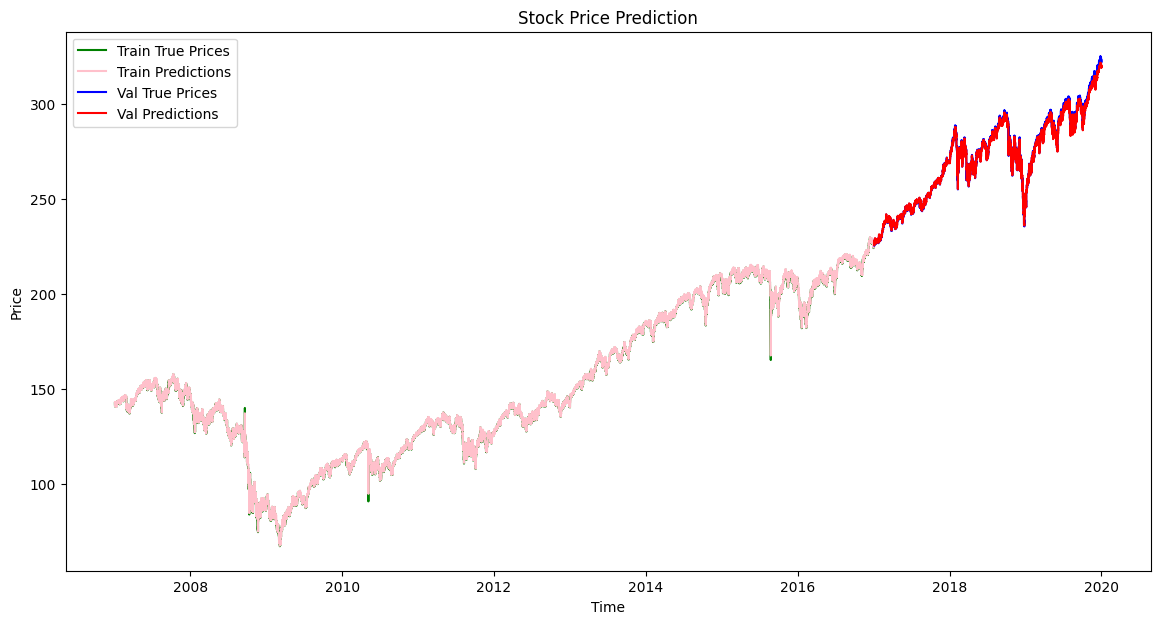

In [11]:
# Plot the predictions and true prices
plt.figure(figsize=(14, 7))
plt.plot(train_dates, train_prices, label='Train True Prices', color='green')
plt.plot(train_dates[train_dates.shape[0] - train_predictions.shape[0]:], train_predictions, label='Train Predictions', color='pink')
plt.plot(val_dates, val_prices, label='Val True Prices', color='blue')
plt.plot(val_dates[val_dates.shape[0] - val_predictions.shape[0]:], val_predictions, label='Val Predictions', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Appendix: performance test (May 29th)

Test predictions saved to 'test_next_close_prediction.csv'.


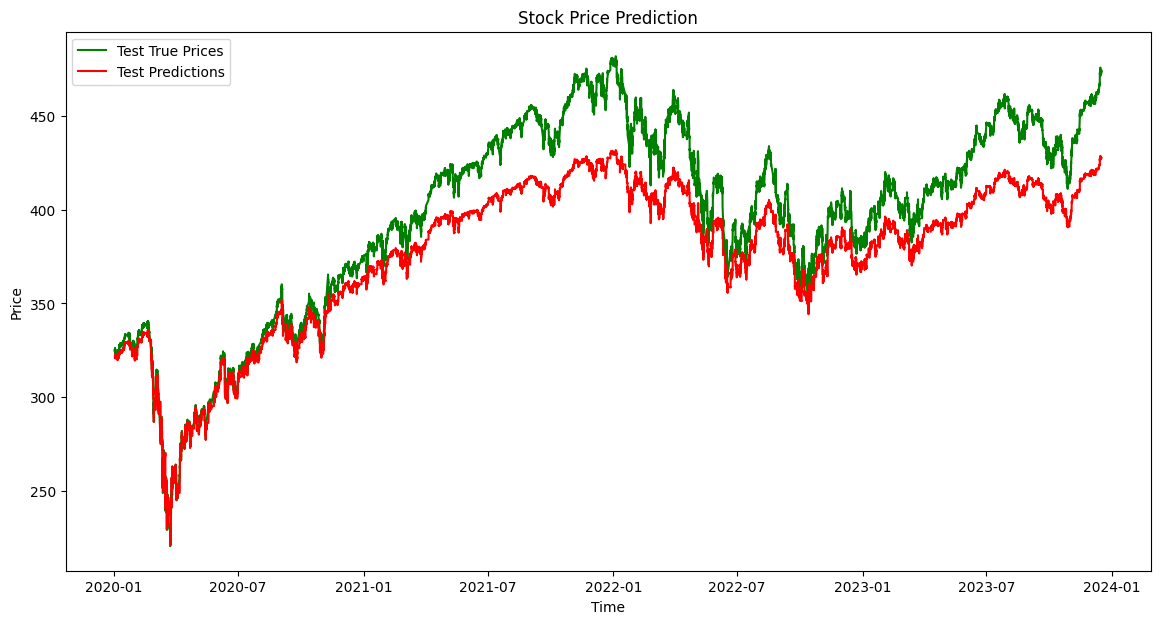

In [7]:
df_test = pd.read_csv('../data/IVV_test_sample.csv')
test_prices = df_test['Close'].values.reshape(-1, 1)
test_dates = pd.to_datetime(df_test['DateTime'])
scaled_test_prices = scaler.transform(test_prices)

test_dataset = StockDataset(scaled_test_prices, sequence_length, prediction_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
model = LSTM(hidden_size=hidden_size, num_layers=num_layers, output_size=prediction_length).to(device)
model.load_state_dict(torch.load('lstm_stock_model_checkpoint.pth'))

test_predictions = predict(model, test_loader)
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).reshape(-1, prediction_length)
test_predictions = np.round(test_predictions, 2)

test_predictions_df = pd.DataFrame(test_predictions, columns=[f'Prediction_{i+1}' for i in range(prediction_length)])
test_predictions_df.to_csv('test_next_close_prediction.csv', index=False)

print("Test predictions saved to 'test_next_close_prediction.csv'.")

plt.figure(figsize=(14, 7))
plt.plot(test_dates, test_prices, label='Test True Prices', color='green')
plt.plot(test_dates[test_dates.shape[0] - test_predictions.shape[0]:], test_predictions, label='Test Predictions', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()